# classification: iris data

## use case understanding

### decription

The purpose of this classification is to classify three different variants of the [iris plant](https://en.wikipedia.org/wiki/Iris_(plant)). For that, we have information rearding the sepal and petal length and width. 

![Image of Iris](https://www.w3resource.com/w3r_images/iris_flower_sepal_and_petal.png)
(image source: https://www.w3resource.com/w3r_images/iris_flower_sepal_and_petal.png)

For additional information regarding the data set read the [wikipedia article](https://en.wikipedia.org/wiki/Iris_flower_data_set).

### goal definition

The classification should generalize very well and be robust.

### set the evaluation metric

We need a good estimator for the generalization. Therefore, we use the accuracy on test data.

## explorative data analysis

### load packages

In [1]:
# load needed packages
import sklearn.datasets as datasets
from sklearn.tree import DecisionTreeClassifier, plot_tree
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.tree import export_graphviz
import pydotplus
import seaborn
import os
from IPython.display import Image
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
import numpy as np
from sklearn import metrics

# load graphviz path
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

### data set loading

In [2]:
#load dataset and get data frame, X and y
iris = datasets.load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

print(f'x_train: {X_train.shape[0]} samples\n',
     f'x_test: {X_test.shape[0]} samples')

x_train: 100 samples
 x_test: 50 samples


In [6]:
# create combine training data set for explorative data analysis
df_train = X_train.copy()
df_train.loc[: ,'target'] = y_train

def convert_target(df, target_name_dict):
    """
    function to change target names to the given target names
    """
    df['target'] = df['target'].astype(str)
    for old_label, new_label in target_name_dict.items():
        df.loc[df['target']==str(old_label), 'target'] = new_label
    return df

target_name_dict = {0:'setosa', 1:'versicolor', 2:'virginica'}
df_train = convert_target(df_train, target_name_dict)

## explorative data analysis / data preparation

In [7]:
# print first rows
df_train.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
136,6.3,3.4,5.6,2.4,virginica
17,5.1,3.5,1.4,0.3,setosa
142,5.8,2.7,5.1,1.9,virginica
59,5.2,2.7,3.9,1.4,versicolor
6,4.6,3.4,1.4,0.3,setosa


In [8]:
# check the frequency of target values
print(Counter(y_train))

def plot_hist(df, col, bin_size=10):
    """
    function to plot histograms of colummns
    """
    plt.hist(df[col], bins = bin_size)
    plt.title(f'Histogram of {df[col].name} (binsize = {bin_size})')
    plt.xlabel(df[col].name)
    plt.ylabel('Frequency')
    plt.show()

# plot histograms of variables
#for col_names in X_train.columns:
#    plot_hist(X_train, col=col_names, bin_size=30)

Counter({0: 34, 2: 33, 1: 33})


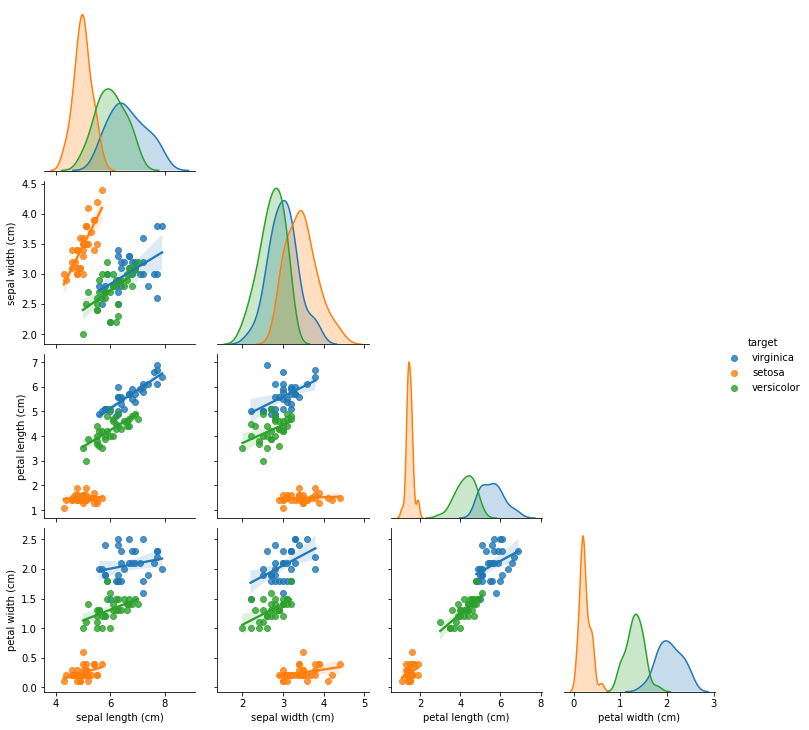

In [9]:
# create pair plot
seaborn.pairplot(df_train, hue='target', corner=True, kind="reg")

## modeling and evaluation

In [10]:
def plot_tree_with_graphviz(decision_tree_model, save_file_path=""):
    """
    function to plot a decision tree and save the images as pdf and png
    
    @param decision_tree_model: model of the decision tree.
                                Format has to be sklearn.tree._classes.DecisionTreeClassifier
    @param save_file_path: path and name of the file to save the file
    @return image_print: returns the image to get printed as IPython.core.display.Image
    """
    # export decision tree as dot data
    dot_data= export_graphviz(decision_tree_model, out_file=None,  
                    filled=True, rounded=True,
                              feature_names = X_test.columns,
                    special_characters=True,
                             class_names = iris.target_names)
    # draw graph
    graph = pydotplus.graph_from_dot_data(dot_data)

    # show graph
    image_print = Image(graph.create_png())
    
    if(save_file_path != ""):
        # create PDF
        graph.write_pdf(save_file_path + '.pdf')

        # create PNG
        graph.write_png(save_file_path + '.png')

    return image_print

### decision tree with train-test-split and plotting

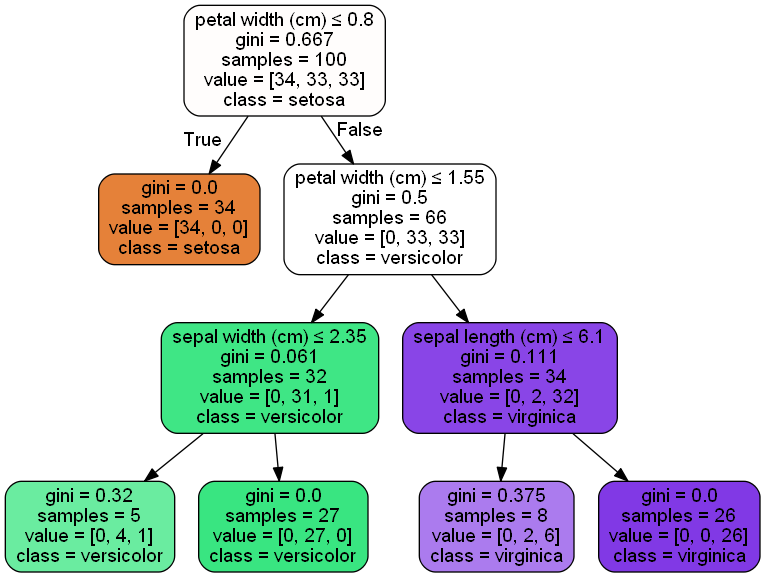

In [11]:
# we use an min samples size in the leafs of 5 to ensure a generalization effect
def run_decision_tree(X_model, y_model, depth=None):
    """create decision tree"""
    model=DecisionTreeClassifier(min_samples_leaf=5, max_depth=depth)
    model.fit(X_model, y_model)
    return model

decision_tree_original = run_decision_tree(X_train, y_train)

# plot the plot_tree_with_graphviz tree
image = plot_tree_with_graphviz(decision_tree_original, save_file_path="figures/iris_decision_original")
image

### get actual accuracy score with cross validation

In [12]:
### Cross validation
def run_decision_tree_CV(X_model, y_model, depth=None, 
                         min_leaf_per_samples=1, scores_print=True):
    """create decision tree with cross-validation"""
    model=DecisionTreeClassifier(min_samples_leaf=min_leaf_per_samples, max_depth=depth)
    scores=cross_val_score(model, X_model, y_model, cv=4)
    if(scores_print): 
        print('Cross-validated scores:', scores)
    return scores

scores = run_decision_tree_CV(X_train, y_train, depth=None, min_leaf_per_samples=5)
print(f'the mean score is: {np.mean(scores)}\n',
f'the std score is: {np.std(scores)}')

Cross-validated scores: [0.96 0.96 0.88 0.96]
the mean score is: 0.94
 the std score is: 0.034641016151377525


### evaluate on test data

In [13]:
def evaluate_decision_tree(model, X_test, y_test):
    """evaluate decision tree"""
    y_pred = model.predict(X_test)
    matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    return matrix

matrix = evaluate_decision_tree(model=decision_tree_original, X_test=X_test, y_test=y_test)
print(f'confusion matrix on the test data: \n {matrix} \n')
y_pred = decision_tree_original.predict(X_test)
print(f'accuracy score on the test data: {accuracy_score(y_test, y_pred)}')

confusion matrix on the test data: 
 [[16  0  0]
 [ 0 14  3]
 [ 0  2 15]] 

accuracy score on the test data: 0.9


### accuracy for leaf size

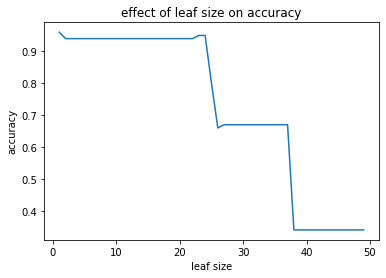

In [18]:
model_accuracy_per_leaf = [[run_decision_tree_CV(X_train, y_train, 
                                                min_leaf_per_samples=leaf_size,
                                                scores_print=False), leaf_size] 
                           for leaf_size in range(1, 50)]
model_accuracy_per_leaf = [[np.mean(i[0]), i[1]] for i in model_accuracy_per_leaf]
plt.plot([item[1] for item in model_accuracy_per_leaf],
        [item[0] for item in model_accuracy_per_leaf])
plt.xlabel('leaf size')
plt.ylabel('accuracy')
plt.title('effect of leaf size on accuracy')
plt.show()
